In [1]:
! pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 8.8 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.model_selection import TimeSeriesSplit
from datetime import datetime, timedelta
from statsmodels.tsa.seasonal import seasonal_decompose
from cycler import cycler
import math

import matplotlib.pyplot as plt
from IPython.display import display
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
pd.options.mode.chained_assignment = None

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
import lightgbm as lgb
from sklearn.svm import SVR
from sklearn.dummy import DummyRegressor

from scipy import stats as st
from sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

import warnings

In [3]:
warnings.filterwarnings("ignore")

In [4]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Проект - модель прогноза спроса на товары ООО “Лента”

# Краткое описание

Необходимо создать алгоритм прогноза спроса на 14 дней для товаров собственного производства. Гранулярность ТК-SKU-День.

# Задача:
Построить модель прогноза спроса на основе мастер данных и данных продаж с учетом разных признаков.

# Цель:

Сгенерировать различные признаки и придумать интерпретируемую, описывающую правильные зависимости (повышение цены вызывает логичное падение спроса), модель прогноза спроса.
Дальше необходимо сделать подневной прогноз спроса на тестовом периоде для каждого товара и магазина, и команда Ленты оценит его качество в сравнении с свершившимся фактом. Метрикой качества будет выступать WAPE, посчитанный на уровне товар, магазин, день. Если есть пропущенные значения и по каким-то товарам не предоставлен прогноз, прогноз считается равным нулю.

# Решение

a. Описание модели прогноза спроса

    i. Признаки

    ii. интерпретация (shapley values)

    iii. кросс-валидация

    iv. алгоритмы

b. Описание алгоритма оптимизации

    i. методология расчетов

    ii. скорость оптимизации

# Важно

- строим прогноз только по активным магазинам
- исключить данные, где информация только о стоимости, а о количестве нет

# Данные

* sales_df_train.csv –данные по продажам за скользящий год для обучения.

st_id – захэшированное id магазина;

pr_sku_id – захэшированное id товара;

date – дата;

pr_sales_type_id – флаг наличия промо;

pr_sales_in_units – число проданных товаров всего (промо и без);

pr_promo_sales_in_units – число проданных товаров с признаком промо;

pr_sales_in_rub – продажи в РУБ всего (промо и без);

pr_promo_sales_in_rub – продажи с признаком промо в РУБ;

* pr_df.csv – данные по товарной иерархии.

От большего к меньшему pr_group_id - pr_cat_id - pr_subcat_id - pr_sku_id.

pr_sku_id – захэшированное id товара;

pr_group_id – захэшированная группа товара;

pr_cat_id – захэшированная категория товара;

pr_subcat_id – захэшированная подкатегория товара;

pr_uom_id - маркер, обозначающий продаётся товар на вес или в ШТ

* st_df.csv – данные по магазинам.

st_id – захэшированное id магазина;

st_city_id – захэшированное id города;

st_division_code id – захэшированное id дивизиона;

st_type_format_id – id формата магазина;

st_type_loc_id – id тип локации/окружения магазина;

st_type_size_id – id типа размера магазина;

st_is_active – флаг активного магазина на данный момент.

* sales_submission.csv – пример файла с результатом работы модели прогноза спроса.

Необходимо подготовить файл в таком же формате, заполнив колонку target предсказаниями (по умолчанию колонка заполнена нулями).

st_id – захэшированное id магазина;

pr_sku_id – захэшированное id товара;

date – дата (день);

target – спрос в ШТ.

## Загрузка данных


https://drive.google.com/file/d/1RSF85xrm9GIqpHBtTjUw2R8cU6EpBIc0/view?usp=sharing

https://drive.google.com/file/d/10oTh-fhQ_i6I1vhrT7UWF4XlSrlLwqdk/view?usp=sharing

https://drive.google.com/file/d/14el2jOc4puinnSsBDWAreNtF7eBYEluo/view?usp=sharing

https://drive.google.com/file/d/1YacI6ki5fgPPYkihllymTnLQ1aHHCaEL/view?usp=sharing

In [5]:
!gdown --id 1RSF85xrm9GIqpHBtTjUw2R8cU6EpBIc0

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1RSF85xrm9GIqpHBtTjUw2R8cU6EpBIc0
To: /content/sales_df_train.csv
100% 86.3M/86.3M [00:00<00:00, 105MB/s]


In [6]:
!gdown --id 10oTh-fhQ_i6I1vhrT7UWF4XlSrlLwqdk

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=10oTh-fhQ_i6I1vhrT7UWF4XlSrlLwqdk
To: /content/pr_df.csv
100% 276k/276k [00:00<00:00, 83.9MB/s]


In [7]:
!gdown --id 14el2jOc4puinnSsBDWAreNtF7eBYEluo

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=14el2jOc4puinnSsBDWAreNtF7eBYEluo
To: /content/st_df.csv
100% 1.39k/1.39k [00:00<00:00, 4.77MB/s]


In [8]:
!gdown --id 1YacI6ki5fgPPYkihllymTnLQ1aHHCaEL

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1YacI6ki5fgPPYkihllymTnLQ1aHHCaEL
To: /content/sales_submission.csv
100% 3.45M/3.45M [00:00<00:00, 118MB/s]


In [9]:
sales_df_train = pd.read_csv('/content/sales_df_train.csv', index_col=[0], parse_dates=[0])

In [10]:
pr_df = pd.read_csv('/content/pr_df.csv', index_col=[0], parse_dates=[0])

In [11]:
sales_submission = pd.read_csv('/content/sales_submission.csv', index_col=[0], parse_dates=[0])

In [12]:
st_df = pd.read_csv('/content/st_df.csv', index_col=[0], parse_dates=[0])

    Получены 4 таблицы с данными

    sales_df_train – данные по продажам за скользящий год для обучения

    pr_df – данные по товарной иерархии

    pr_st – данные по магазинам

    sales_submission – пример файла с результатом работы модели прогноза спроса

## Исследовательский анализ

### Общая *информация*

#### Таблица sales_df_train
данные по продажам за скользящий год для обучения

st_id – захэшированное id магазина;

pr_sku_id – захэшированное id товара;

date – дата;

pr_sales_type_id – флаг наличия промо;

pr_sales_in_units – число проданных товаров всего (промо и без);

pr_promo_sales_in_units – число проданных товаров с признаком промо;

pr_sales_in_rub – продажи в РУБ всего (промо и без);

pr_promo_sales_in_rub – продажи с признаком промо в РУБ;

In [13]:
sales_df_train.head(5)

,pr_sku_id,date,pr_sales_type_id,pr_sales_in_units,pr_promo_sales_in_units,pr_sales_in_rub,pr_promo_sales_in_rub
st_id,,,,,,,
c81e728d9d4c2f636f067f89cc14862c,c7b711619071c92bef604c7ad68380dd,2022-10-20,1,5.0,5.0,825.0,825.0
42a0e188f5033bc65bf8d78622277c4e,68f441429e73dbd33b81f95da31576e9,2023-01-29,0,4.0,0.0,196.0,0.0
1ecfb463472ec9115b10c292ef8bc986,22988026fe85fde60d8bf777ab6bc3b4,2023-03-02,0,1.0,0.0,78.0,0.0
42a0e188f5033bc65bf8d78622277c4e,8e887cf8e64ab8e7173701a979476567,2023-04-05,1,0.0,0.0,69.0,69.0
16a5cdae362b8d27a1d8f8c7b78b4330,e6fc24ca846339d204b0b50e9f772484,2023-02-17,0,1.0,0.0,161.0,0.0


Данные и размер таблицы

In [14]:
sales_df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 883015 entries, c81e728d9d4c2f636f067f89cc14862c to 16a5cdae362b8d27a1d8f8c7b78b4330
Data columns (total 7 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   pr_sku_id                883015 non-null  object 
 1   date                     883015 non-null  object 
 2   pr_sales_type_id         883015 non-null  int64  
 3   pr_sales_in_units        883015 non-null  float64
 4   pr_promo_sales_in_units  883015 non-null  float64
 5   pr_sales_in_rub          883015 non-null  float64
 6   pr_promo_sales_in_rub    883015 non-null  float64
dtypes: float64(4), int64(1), object(2)
memory usage: 53.9+ MB


    Количество объектов 883015 - выполнено операций продажи/получено чеков за период

    Столбцов 7 - характеристики каждого чека (в роли индекса объекта выступает хэшкод магазина)

    Типы данных object, int64, float64

    Столбец date отображает дату, тип object, необходимо форматировать в тип данных datetime.
                
    Даты отображаются не в хронологическом порядке, следует сортировать по дате от меньшего значения к большему.

In [15]:
sales_df_train.describe()

,pr_sales_type_id,pr_sales_in_units,pr_promo_sales_in_units,pr_sales_in_rub,pr_promo_sales_in_rub
count,883015.000000,883015.000000,883015.000000,883015.000000,883015.000000
mean,0.406486,5.037956,2.230010,596.705181,294.766561
std,0.491178,13.402984,11.063288,1577.366179,1402.764168
min,0.000000,-39.000000,-39.000000,-3373.000000,-3373.000000
25%,0.000000,1.000000,0.000000,98.000000,0.000000
50%,0.000000,2.000000,0.000000,224.000000,0.000000
75%,1.000000,4.000000,1.000000,540.000000,127.000000
max,1.000000,2348.000000,2348.000000,183265.000000,183265.000000


Недопустимых аномалий и выбросов нет. отрицательные значения проанализируем далее.

Пропуски

Убедимся, что их нет

In [16]:
sales_df_train.isna().sum()

pr_sku_id                  0
date                       0
pr_sales_type_id           0
pr_sales_in_units          0
pr_promo_sales_in_units    0
pr_sales_in_rub            0
pr_promo_sales_in_rub      0
dtype: int64

Уникальность значений

In [17]:
sales_df_train.nunique()

pr_sku_id                   1991
date                         352
pr_sales_type_id               2
pr_sales_in_units            392
pr_promo_sales_in_units      357
pr_sales_in_rub            12313
pr_promo_sales_in_rub      10874
dtype: int64

st_id – захэшированное id магазина;

pr_sku_id – захэшированное id товара;

date – дата;

pr_sales_type_id – флаг наличия промо;

pr_sales_in_units – число проданных товаров всего (промо и без);

pr_promo_sales_in_units – число проданных товаров с признаком промо;

pr_sales_in_rub – продажи в РУБ всего (промо и без);

pr_promo_sales_in_rub – продажи с признаком промо в РУБ

    Количество уникальных значений значительно меньше общего числа объектов, это говорит о том, что значения повторяются,
    т.е. это отражает "ассортимент" каждой характеристики. Наример date - 352 разных дня  

Дубликаты

In [18]:
sales_df_train[sales_df_train.duplicated()].head(20)

,pr_sku_id,date,pr_sales_type_id,pr_sales_in_units,pr_promo_sales_in_units,pr_sales_in_rub,pr_promo_sales_in_rub
st_id,,,,,,,
c81e728d9d4c2f636f067f89cc14862c,5e664d6988c6d6827cbaaafb0bc7f103,2022-11-30,0,1.0,0.0,180.0,0.0
42a0e188f5033bc65bf8d78622277c4e,4e2b6b1dddc1ece38fbbaddad13c8e11,2023-03-06,0,5.0,0.0,206.0,0.0
16a5cdae362b8d27a1d8f8c7b78b4330,2dc922d957188fb51dd2bd50ec9b555a,2023-04-03,0,1.0,0.0,41.0,0.0
42a0e188f5033bc65bf8d78622277c4e,8353aa07fab6dbeb7962e7a9ba2c3e53,2023-05-04,0,1.0,0.0,223.0,0.0
6364d3f0f495b6ab9dcf8d3b5c6e0b01,0e97d6e7124d6cc9623650201236cd52,2022-09-30,0,2.0,0.0,123.0,0.0
16a5cdae362b8d27a1d8f8c7b78b4330,e098042910615ad78cc7c93d90d591f8,2023-04-27,0,1.0,0.0,49.0,0.0
c81e728d9d4c2f636f067f89cc14862c,ac97437364b6701a12e48e3d4559d251,2023-01-10,0,1.0,0.0,127.0,0.0
fa7cdfad1a5aaf8370ebeda47a1ff1c3,3ab75955a9c0ce15f6ca004ff088e7f6,2022-12-01,0,1.0,0.0,74.0,0.0
6364d3f0f495b6ab9dcf8d3b5c6e0b01,6629d8e0d18c0b83c15006570566598f,2022-11-06,0,1.0,0.0,41.0,0.0


    Дублирование только по хэшкоду магазина или товара.

#### Таблица - pr_df
данные по товарной иерархии

pr_df.csv – данные по товарной иерархии.

От большего к меньшему pr_group_id - pr_cat_id - pr_subcat_id - pr_sku_id.

pr_sku_id – захэшированное id товара;

pr_group_id – захэшированная группа товара;

pr_cat_id – захэшированная категория товара;

pr_subcat_id – захэшированная подкатегория товара;

pr_uom_id - маркер, обозначающий продаётся товар на вес или в ШТ

In [19]:
pr_df.head()

,pr_group_id,pr_cat_id,pr_subcat_id,pr_uom_id
pr_sku_id,,,,
fd064933250b0bfe4f926b867b0a5ec8,c74d97b01eae257e44aa9d5bade97baf,1bc0249a6412ef49b07fe6f62e6dc8de,ca34f669ae367c87f0e75dcae0f61ee5,17
71c9661741caf40a92a32d1cc8206c04,c74d97b01eae257e44aa9d5bade97baf,c559da2ba967eb820766939a658022c8,e06f5ed77191826c212c30722f2cc5a2,17
00b72c2f01a1512cbb1d3f33319bac93,c74d97b01eae257e44aa9d5bade97baf,1bc0249a6412ef49b07fe6f62e6dc8de,d407a3ebb4ab9b0d68b224486f8b8dad,17
9bc40cd2fe4f188f402bb41548c5e15c,c74d97b01eae257e44aa9d5bade97baf,1bc0249a6412ef49b07fe6f62e6dc8de,ca34f669ae367c87f0e75dcae0f61ee5,17
3a74a370c8eb032acb11ad9119242b8f,c74d97b01eae257e44aa9d5bade97baf,c559da2ba967eb820766939a658022c8,e06f5ed77191826c212c30722f2cc5a2,17


Данные и размер таблицы

In [20]:
pr_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2050 entries, fd064933250b0bfe4f926b867b0a5ec8 to dbfce512dcdabc6b6e2724b6ec44efda
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   pr_group_id   2050 non-null   object
 1   pr_cat_id     2050 non-null   object
 2   pr_subcat_id  2050 non-null   object
 3   pr_uom_id     2050 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 80.1+ KB


    Количество объектов 2050

    Столбцов 4 - количество групп иерархии товара(в роли индекса объекта выступает хэшкод товара)

    Типы данных object, int64

    Пропусков нет

In [21]:
pr_df.describe()

,pr_uom_id
count,2050.000000
mean,7.017561
std,7.752371
min,1.000000
25%,1.000000
50%,1.000000
75%,17.000000
max,17.000000


Недопустимых аномалий и выбросов нет.

Пропуски

Убедимся, что их нет

In [22]:
pr_df.isna().sum()

pr_group_id     0
pr_cat_id       0
pr_subcat_id    0
pr_uom_id       0
dtype: int64

Уникальность значений

In [23]:
pr_df.nunique()

pr_group_id       9
pr_cat_id        43
pr_subcat_id    170
pr_uom_id         2
dtype: int64

pr_sku_id – захэшированное id товара;

pr_group_id – захэшированная группа товара;

pr_cat_id – захэшированная категория товара;

pr_subcat_id – захэшированная подкатегория товара;

pr_uom_id - маркер, обозначающий продаётся товар на вес или в ШТ

    "Ассортимент" категорий разного уровня

Дубликаты

In [24]:
pr_df[pr_df.duplicated()].head(20)

,pr_group_id,pr_cat_id,pr_subcat_id,pr_uom_id
pr_sku_id,,,,
9bc40cd2fe4f188f402bb41548c5e15c,c74d97b01eae257e44aa9d5bade97baf,1bc0249a6412ef49b07fe6f62e6dc8de,ca34f669ae367c87f0e75dcae0f61ee5,17
3a74a370c8eb032acb11ad9119242b8f,c74d97b01eae257e44aa9d5bade97baf,c559da2ba967eb820766939a658022c8,e06f5ed77191826c212c30722f2cc5a2,17
cff633e270708ced01bc585eb1421667,c74d97b01eae257e44aa9d5bade97baf,c559da2ba967eb820766939a658022c8,e06f5ed77191826c212c30722f2cc5a2,17
1cfd4c9cd7289a63dc2492f2b0200868,c74d97b01eae257e44aa9d5bade97baf,1bc0249a6412ef49b07fe6f62e6dc8de,d407a3ebb4ab9b0d68b224486f8b8dad,17
c7e043e0f743476582f79ba27ba3c51f,c74d97b01eae257e44aa9d5bade97baf,1bc0249a6412ef49b07fe6f62e6dc8de,ca34f669ae367c87f0e75dcae0f61ee5,17
f9ee6d53edebe412feb1118b618900c8,c74d97b01eae257e44aa9d5bade97baf,1bc0249a6412ef49b07fe6f62e6dc8de,d407a3ebb4ab9b0d68b224486f8b8dad,17
e95b9bb287e5571345c0e94f3118d667,c74d97b01eae257e44aa9d5bade97baf,c559da2ba967eb820766939a658022c8,e06f5ed77191826c212c30722f2cc5a2,17
530b5dc58f1ad1eebf282a89c432c006,c74d97b01eae257e44aa9d5bade97baf,1bc0249a6412ef49b07fe6f62e6dc8de,d407a3ebb4ab9b0d68b224486f8b8dad,17
cf0c31c18f1ed7065e20442bc991df9e,c74d97b01eae257e44aa9d5bade97baf,1bc0249a6412ef49b07fe6f62e6dc8de,ca34f669ae367c87f0e75dcae0f61ee5,17


    Полного дублирования нет - только по отдельным характеристикам товара.

#### Таблица - st_df
данные по магазинам.

st_id – захэшированное id магазина;

st_city_id – захэшированное id города;

st_division_code id – захэшированное id дивизиона;

st_type_format_id – id формата магазина;

st_type_loc_id – id тип локации/окружения магазина;

st_type_size_id – id типа размера магазина;

st_is_active – флаг активного магазина на данный момент.

In [25]:
st_df.head(5)

,st_city_id,st_division_code,st_type_format_id,st_type_loc_id,st_type_size_id,st_is_active
st_id,,,,,,
1aa057313c28fa4a40c5bc084b11d276,1587965fb4d4b5afe8428a4a024feb0d,81b4dd343f5880df806d4c5d4a846c64,4,3,19,0
bd470ca955d9497bbcb808e59952fffc,955d864a62659945cc9434898e275deb,e26072c92d8fe0738df44d571d5f5e8b,4,3,19,1
6364d3f0f495b6ab9dcf8d3b5c6e0b01,b8b4b727d6f5d1b61fff7be687f7970f,da742b3cfca5388aaf9af28a726a3c30,1,1,12,1
1ecfb463472ec9115b10c292ef8bc986,908c9a564a86426585b29f5335b619bc,429a86ff6336c144ddaf6144f52ab52c,2,1,28,1
16a5cdae362b8d27a1d8f8c7b78b4330,c1f75cc0f7fe269dd0fd9bd5e24f9586,296bd0cc6e735f9d7488ebc8fbc19130,1,2,8,1


Данные и размер таблицы

In [26]:
st_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12 entries, 1aa057313c28fa4a40c5bc084b11d276 to 084a8a9aa8cced9175bd07bc44998e75
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   st_city_id         12 non-null     object
 1   st_division_code   12 non-null     object
 2   st_type_format_id  12 non-null     int64 
 3   st_type_loc_id     12 non-null     int64 
 4   st_type_size_id    12 non-null     int64 
 5   st_is_active       12 non-null     int64 
dtypes: int64(4), object(2)
memory usage: 672.0+ bytes


    Количество объектов 12 - количество магазинов, участвующих в прогнозе

    Столбцов 6 - количество характеристик магазина (в роли индекса объекта выступает хэшкод магазина)

    Типы данных object, int64

    Пропусков нет

In [27]:
st_df.describe()

,st_type_format_id,st_type_loc_id,st_type_size_id,st_is_active
count,12.000000,12.000000,12.000000,12.000000
mean,2.333333,1.916667,16.750000,0.833333
std,1.497473,0.996205,7.557356,0.389249
min,1.000000,1.000000,8.000000,0.000000
25%,1.000000,1.000000,12.000000,1.000000
50%,1.500000,1.500000,15.500000,1.000000
75%,4.000000,3.000000,19.250000,1.000000
max,4.000000,3.000000,32.000000,1.000000


Недопустимых аномалий и выбросов нет.

Пропуски

Убедимся, что их нет

In [28]:
st_df.isna().sum()

st_city_id           0
st_division_code     0
st_type_format_id    0
st_type_loc_id       0
st_type_size_id      0
st_is_active         0
dtype: int64

Уникальность значений

In [29]:
st_df.nunique()

st_city_id           7
st_division_code     6
st_type_format_id    3
st_type_loc_id       3
st_type_size_id      6
st_is_active         2
dtype: int64

st_id – захэшированное id магазина;

st_city_id – захэшированное id города;

st_division_code id – захэшированное id дивизиона;

st_type_format_id – id формата магазина;

st_type_loc_id – id тип локации/окружения магазина;

st_type_size_id – id типа размера магазина;

st_is_active – флаг активного магазина на данный момент.

    "Ассортимент" характеристик магазина

Дубликаты

In [30]:
st_df[st_df.duplicated()]

,st_city_id,st_division_code,st_type_format_id,st_type_loc_id,st_type_size_id,st_is_active
st_id,,,,,,
42a0e188f5033bc65bf8d78622277c4e,b8b4b727d6f5d1b61fff7be687f7970f,da742b3cfca5388aaf9af28a726a3c30,1,1,12,1


    Полного дублирования нет

#### Таблица - sales_submission
пример файла с результатом работы модели прогноза спроса.

Необходимо подготовить файл в таком же формате, заполнив колонку target предсказаниями (по умолчанию колонка заполнена нулями).

st_id – захэшированное id магазина;

pr_sku_id – захэшированное id товара;

date – дата (день);

target – спрос в ШТ

In [31]:
sales_submission.head(5)

,pr_sku_id,date,target
st_id,,,
16a5cdae362b8d27a1d8f8c7b78b4330,0045ebdb1069ff4b3dd3efe628c39cd3,2023-07-20,0
16a5cdae362b8d27a1d8f8c7b78b4330,00661699f543753ec7e911a64b9fd2f6,2023-07-20,0
16a5cdae362b8d27a1d8f8c7b78b4330,0094042bfeae507dc7f62acc8e5ed03a,2023-07-20,0
16a5cdae362b8d27a1d8f8c7b78b4330,0169529ff660adcac9b7e354e0c4b882,2023-07-20,0
16a5cdae362b8d27a1d8f8c7b78b4330,01e4734745e97e52d3213449e1a05dd7,2023-07-20,0


Данные и размер таблицы

In [32]:
sales_submission.info()

<class 'pandas.core.frame.DataFrame'>
Index: 43694 entries, 16a5cdae362b8d27a1d8f8c7b78b4330 to fa7cdfad1a5aaf8370ebeda47a1ff1c3
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   pr_sku_id  43694 non-null  object
 1   date       43694 non-null  object
 2   target     43694 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 1.3+ MB


    Количество объектов 43694 - количество прогнозов, которые нужно сделать в зависимости от товара, магазина и даты.

    Столбцов 4 - характеристики объекта прогноза (в роли индекса объекта выступает хэшкод магазина)

    Типы данных object, int64

    Пропусков нет

    В итоге анализа общей информации всех 4х таблиц:

    Типы данных таблиц object, int64, float64

    Дубликатов и пропусков нет

    В таблице sales_df_train столбец date отображает дату, тип object, необходимо форматировать в тип данных datetime.
                
    Даты отображаются не в хронологическом порядке, следует сортировать по дате от меньшего значения к большему.

### Предварительная обработка данных
по результатам анализа общей информации


Проведем форматирование столбца date

In [33]:
sales_df_train['date'] =  pd.to_datetime(sales_df_train['date'])

Проверка полученного типа данных

In [34]:
type(sales_df_train.date[0])

pandas._libs.tslibs.timestamps.Timestamp

In [35]:
sales_df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 883015 entries, c81e728d9d4c2f636f067f89cc14862c to 16a5cdae362b8d27a1d8f8c7b78b4330
Data columns (total 7 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   pr_sku_id                883015 non-null  object        
 1   date                     883015 non-null  datetime64[ns]
 2   pr_sales_type_id         883015 non-null  int64         
 3   pr_sales_in_units        883015 non-null  float64       
 4   pr_promo_sales_in_units  883015 non-null  float64       
 5   pr_sales_in_rub          883015 non-null  float64       
 6   pr_promo_sales_in_rub    883015 non-null  float64       
dtypes: datetime64[ns](1), float64(4), int64(1), object(1)
memory usage: 53.9+ MB


Проведем сортировку от меньшей даты к большей столбца date

In [36]:
sales_df_train = sales_df_train.sort_values(by='date')

Объеденим 3 таблицы в одну по захэшированному id товара и id магазина

* sales_df_train.csv –данные по продажам за скользящий год для обучения.

st_id – захэшированное id магазина;

pr_sku_id – захэшированное id товара;

date – дата;

pr_sales_type_id – флаг наличия промо;

pr_sales_in_units – число проданных товаров всего (промо и без);

pr_promo_sales_in_units – число проданных товаров с признаком промо;

pr_sales_in_rub – продажи в РУБ всего (промо и без);

pr_promo_sales_in_rub – продажи с признаком промо в РУБ;

* pr_df.csv – данные по товарной иерархии.

От большего к меньшему pr_group_id - pr_cat_id - pr_subcat_id - pr_sku_id.

pr_sku_id – захэшированное id товара;

pr_group_id – захэшированная группа товара;

pr_cat_id – захэшированная категория товара;

pr_subcat_id – захэшированная подкатегория товара;

pr_uom_id - маркер, обозначающий продаётся товар на вес или в ШТ

* st_df.csv – данные по магазинам.

st_id – захэшированное id магазина;

st_city_id – захэшированное id города;

st_division_code id – захэшированное id дивизиона;

st_type_format_id – id формата магазина;

st_type_loc_id – id тип локации/окружения магазина;

st_type_size_id – id типа размера магазина;

st_is_active – флаг активного магазина на данный момент.

* sales_submission.csv – пример файла с результатом работы модели прогноза спроса.

Необходимо подготовить файл в таком же формате, заполнив колонку target предсказаниями (по умолчанию колонка заполнена нулями).

st_id – захэшированное id магазина;

pr_sku_id – захэшированное id товара;

date – дата (день);

target – спрос в ШТ.

Что бы не потерять после объединения данные , которые выступают в роли индекса - добавим новый индекс

In [37]:
sales_df_train.reset_index(inplace= True)
pr_df.reset_index(inplace= True)
st_df.reset_index(inplace= True)

In [38]:
df_total = sales_df_train.merge(pr_df, on='pr_sku_id', how='left').merge(st_df, on='st_id', how='left')

In [39]:
df_total.head(5)

,st_id,pr_sku_id,date,pr_sales_type_id,pr_sales_in_units,pr_promo_sales_in_units,pr_sales_in_rub,pr_promo_sales_in_rub,pr_group_id,pr_cat_id,pr_subcat_id,pr_uom_id,st_city_id,st_division_code,st_type_format_id,st_type_loc_id,st_type_size_id,st_is_active
0,42a0e188f5033bc65bf8d78622277c4e,5781a2637b476d781eb3134581b32044,2022-08-01,0,2.0,0.0,463.0,0.0,6512bd43d9caa6e02c990b0a82652dca,e58cc5ca94270acaceed13bc82dfedf7,aa50d6506c1e1b3f030c0b19962eb625,1,b8b4b727d6f5d1b61fff7be687f7970f,da742b3cfca5388aaf9af28a726a3c30,1,1,12,1
1,c81e728d9d4c2f636f067f89cc14862c,82704fa1c2dbdb928bf4eed0667260dd,2022-08-01,0,2.0,0.0,204.0,0.0,aab3238922bcc25a6f606eb525ffdc56,9701a1c165dd9420816bfec5edd6c2b1,c01c475ac8d447730ece97d846cc4f25,1,908c9a564a86426585b29f5335b619bc,429a86ff6336c144ddaf6144f52ab52c,1,1,8,1
2,c81e728d9d4c2f636f067f89cc14862c,0cc8850f66397af21700e3c060a5210c,2022-08-01,0,9.0,0.0,639.0,0.0,c74d97b01eae257e44aa9d5bade97baf,c559da2ba967eb820766939a658022c8,1e2248e0a1305fdf1dca5510e06a2b96,17,908c9a564a86426585b29f5335b619bc,429a86ff6336c144ddaf6144f52ab52c,1,1,8,1
3,fa7cdfad1a5aaf8370ebeda47a1ff1c3,c4a665596d4f67cecb7542c9fad407ee,2022-08-01,0,13.0,0.0,1734.0,0.0,c20ad4d76fe97759aa27a0c99bff6710,fb2fcd534b0ff3bbed73cc51df620323,45551f4c29881972ae5ed3666a5b1b8b,1,885fe656777008c335ac96072a45be15,296bd0cc6e735f9d7488ebc8fbc19130,1,1,12,1
4,c81e728d9d4c2f636f067f89cc14862c,dce1f234d6424aa61f8e7ce0baffd9af,2022-08-01,0,2.0,0.0,313.0,0.0,aab3238922bcc25a6f606eb525ffdc56,9701a1c165dd9420816bfec5edd6c2b1,c01c475ac8d447730ece97d846cc4f25,1,908c9a564a86426585b29f5335b619bc,429a86ff6336c144ddaf6144f52ab52c,1,1,8,1


Переименуем столбцы для лучшего восприятия

pr_sales_type_id – флаг наличия промо - promo

pr_sales_in_units – число проданных товаров всего (промо и без) - sale_total

pr_promo_sales_in_units – число проданных товаров с признаком промо - sale_promo

pr_group_id – захэшированная группа товара - group

pr_cat_id – захэшированная категория товара - cat

pr_subcat_id – захэшированная подкатегория товара - subcat

pr_uom_id - маркер, обозначающий продаётся товар на вес или в ШТ - uom

st_city_id – захэшированное id города - city

st_division_code id – захэшированное id дивизиона - division

st_type_format_id – id формата магазина - format

st_type_loc_id – id тип локации/окружения магазина - location

st_type_size_id – id типа размера магазина - st_size

st_is_active – флаг активного магазина на данный момент - activ



In [40]:
df_total.rename(columns = {'pr_sales_type_id' : 'promo',
                    'pr_sales_in_units' : 'sale',
                    'pr_promo_sales_in_units' : 'sale_promo',
                    'pr_group_id' : 'group',
                    'pr_cat_id' : 'cat',
                    'pr_subcat_id' : 'subcat',
                    'pr_uom_id' : 'uom',
                    'st_city_id' : 'city',
                    'st_division_code id' : 'division',
                    'st_type_format_id' : 'format',
                    'st_type_loc_id' : 'location',
                    'st_type_size_id' : 'st_size',
                    'st_is_active' : 'activ'},
                              inplace = True )

Для логической последовательности характеристик объектов изменяем порядок столбцов

Исключим столбцы, которые не нужны для обучения

'pr_sales_in_rub', 'pr_promo_sales_in_rub' - целевой признак выраженный в рублях, нужен в объеме продаж.

In [41]:
df_total = df_total[['date', 'promo', 'sale', 'sale_promo', 'st_id', 'pr_sku_id',
       'group', 'cat', 'subcat', 'uom', 'city', 'st_division_code', 'format',
       'location', 'st_size', 'activ']]

In [42]:
df_total.head()

,date,promo,sale,sale_promo,st_id,pr_sku_id,group,cat,subcat,uom,city,st_division_code,format,location,st_size,activ
0,2022-08-01,0,2.0,0.0,42a0e188f5033bc65bf8d78622277c4e,5781a2637b476d781eb3134581b32044,6512bd43d9caa6e02c990b0a82652dca,e58cc5ca94270acaceed13bc82dfedf7,aa50d6506c1e1b3f030c0b19962eb625,1,b8b4b727d6f5d1b61fff7be687f7970f,da742b3cfca5388aaf9af28a726a3c30,1,1,12,1
1,2022-08-01,0,2.0,0.0,c81e728d9d4c2f636f067f89cc14862c,82704fa1c2dbdb928bf4eed0667260dd,aab3238922bcc25a6f606eb525ffdc56,9701a1c165dd9420816bfec5edd6c2b1,c01c475ac8d447730ece97d846cc4f25,1,908c9a564a86426585b29f5335b619bc,429a86ff6336c144ddaf6144f52ab52c,1,1,8,1
2,2022-08-01,0,9.0,0.0,c81e728d9d4c2f636f067f89cc14862c,0cc8850f66397af21700e3c060a5210c,c74d97b01eae257e44aa9d5bade97baf,c559da2ba967eb820766939a658022c8,1e2248e0a1305fdf1dca5510e06a2b96,17,908c9a564a86426585b29f5335b619bc,429a86ff6336c144ddaf6144f52ab52c,1,1,8,1
3,2022-08-01,0,13.0,0.0,fa7cdfad1a5aaf8370ebeda47a1ff1c3,c4a665596d4f67cecb7542c9fad407ee,c20ad4d76fe97759aa27a0c99bff6710,fb2fcd534b0ff3bbed73cc51df620323,45551f4c29881972ae5ed3666a5b1b8b,1,885fe656777008c335ac96072a45be15,296bd0cc6e735f9d7488ebc8fbc19130,1,1,12,1
4,2022-08-01,0,2.0,0.0,c81e728d9d4c2f636f067f89cc14862c,dce1f234d6424aa61f8e7ce0baffd9af,aab3238922bcc25a6f606eb525ffdc56,9701a1c165dd9420816bfec5edd6c2b1,c01c475ac8d447730ece97d846cc4f25,1,908c9a564a86426585b29f5335b619bc,429a86ff6336c144ddaf6144f52ab52c,1,1,8,1


In [43]:
df_total.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 883015 entries, 0 to 883014
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   date              883015 non-null  datetime64[ns]
 1   promo             883015 non-null  int64         
 2   sale              883015 non-null  float64       
 3   sale_promo        883015 non-null  float64       
 4   st_id             883015 non-null  object        
 5   pr_sku_id         883015 non-null  object        
 6   group             883015 non-null  object        
 7   cat               883015 non-null  object        
 8   subcat            883015 non-null  object        
 9   uom               883015 non-null  int64         
 10  city              883015 non-null  object        
 11  st_division_code  883015 non-null  object        
 12  format            883015 non-null  int64         
 13  location          883015 non-null  int64         
 14  st_s

Проверим данные на мультиколлинеарность

In [44]:
df_total.corr()

,promo,sale,sale_promo,uom,format,location,st_size,activ
promo,1.000000,0.027669,0.243565,-0.054975,0.038529,-0.002301,0.015450,0.007572
sale,0.027669,1.000000,0.783206,0.042366,-0.044699,0.001076,-0.050026,0.004085
sale_promo,0.243565,0.783206,1.000000,-0.035563,-0.023371,-0.004220,-0.024663,0.004201
uom,-0.054975,0.042366,-0.035563,1.000000,0.195747,0.073560,0.122357,-0.037054
format,0.038529,-0.044699,-0.023371,0.195747,1.000000,0.359484,0.662690,-0.200869
location,-0.002301,0.001076,-0.004220,0.073560,0.359484,1.000000,-0.193071,-0.117443
st_size,0.015450,-0.050026,-0.024663,0.122357,0.662690,-0.193071,1.000000,-0.049172
activ,0.007572,0.004085,0.004201,-0.037054,-0.200869,-0.117443,-0.049172,1.000000


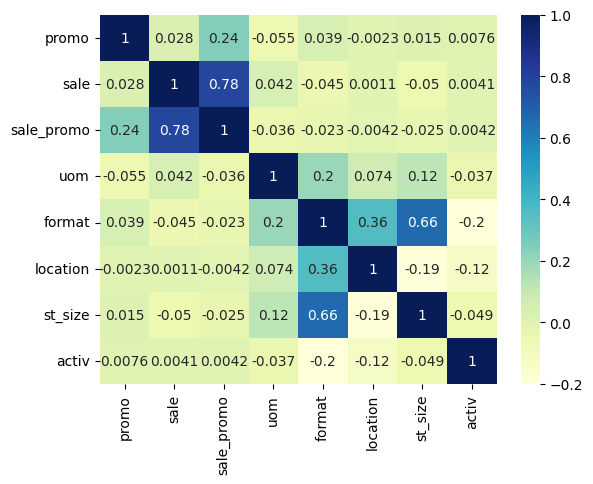

In [45]:
df_plot = sns.heatmap(df_total.corr(), cmap="YlGnBu", annot=True)
plt.show()

Анализ мультиколлинеарности показал, что признаки sale и sale_promo сильно коррелируют. На стадии обучения моделей удалим признак sale_promo, т.к sale - таргет

### Анализ признаков - характеристик объектов

Начало, конец и продолжительность периода

In [46]:
df_total.date.min(), df_total.date.max(), df_total.date.max() - df_total.date.min()

(Timestamp('2022-08-01 00:00:00'),
 Timestamp('2023-07-18 00:00:00'),
 Timedelta('351 days 00:00:00'))

Период времени с 01.08.2022 до 18.07.2023 равен 351 дню. Это не позволит оценить сезонность на уровне года и отчасти на уровне месяцев - только с привязкой к большим ежегодным праздникам.

In [47]:
df_total.promo.mean()

0.4064857335379354

Доля продаж по промо - 0.4, без - 0.6. Большинство продадаж осуществлено без промоакций, хотя их доля очень существенна 0.4, почти половина всех продаж.

Разделим датасет на 2: продажи с промо и без. Обучение моделей можно провести на эти 2 условия спроса.

Объем продаж без промо

In [48]:
df = df_total[df_total['promo'] == 0]
len(df)

524082

Объем продаж промо

In [49]:
df_promo = df_total[df_total['promo'] == 1]
len(df_promo)

358933

In [50]:
len(df) + len(df_promo) - len(df_total)

0

### Уровень спроса - зависимость

#### Период времени, тренд, сезонность

In [51]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 524082 entries, 0 to 883014
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   date              524082 non-null  datetime64[ns]
 1   promo             524082 non-null  int64         
 2   sale              524082 non-null  float64       
 3   sale_promo        524082 non-null  float64       
 4   st_id             524082 non-null  object        
 5   pr_sku_id         524082 non-null  object        
 6   group             524082 non-null  object        
 7   cat               524082 non-null  object        
 8   subcat            524082 non-null  object        
 9   uom               524082 non-null  int64         
 10  city              524082 non-null  object        
 11  st_division_code  524082 non-null  object        
 12  format            524082 non-null  int64         
 13  location          524082 non-null  int64         
 14  st_s

In [52]:
df.describe()

,promo,sale,sale_promo,uom,format,location,st_size,activ
count,524082.0,524082.000000,524082.0,524082.000000,524082.000000,524082.000000,524082.000000,524082.000000
mean,0.0,4.731052,0.0,7.101122,1.083189,1.207752,11.406675,0.998994
std,0.0,10.413981,0.0,7.771382,0.374919,0.431304,4.396941,0.031695
min,0.0,-27.000000,0.0,1.000000,1.000000,1.000000,8.000000,0.000000
25%,0.0,1.000000,0.0,1.000000,1.000000,1.000000,8.000000,1.000000
50%,0.0,2.000000,0.0,1.000000,1.000000,1.000000,12.000000,1.000000
75%,0.0,4.000000,0.0,17.000000,1.000000,1.000000,12.000000,1.000000
max,0.0,1033.000000,0.0,17.000000,4.000000,3.000000,32.000000,1.000000


Присутствуют отрицательные значения sale - вероятно, возвраты

Посмотрим на объемы продаж с промо и без на графике по датам

<Axes: title={'center': 'Объемы продаж весь период'}, xlabel='date'>

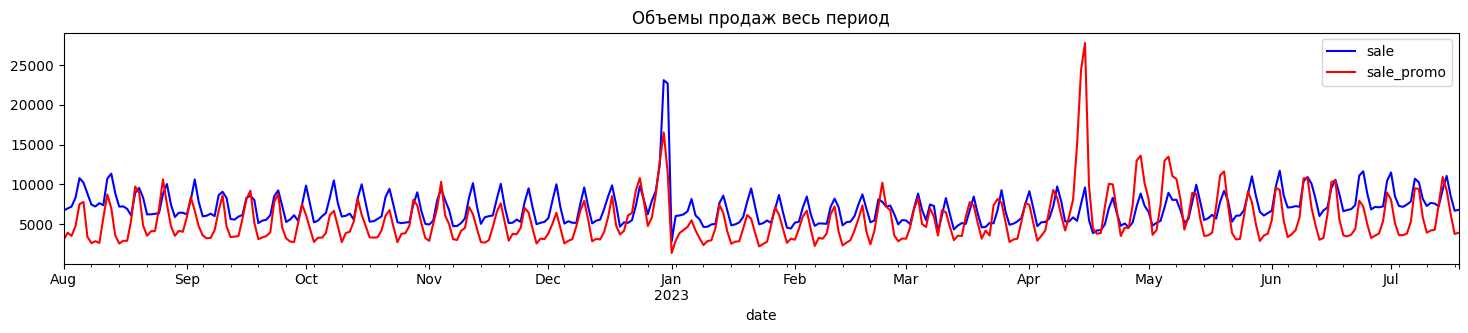

In [53]:
df.groupby('date')['sale'].sum().plot(legend=True,figsize=(18,3), color='b', title='Объемы продаж весь период')
df_promo.groupby('date')['sale_promo'].sum().plot(legend=True,figsize=(18,3), color='r')

На графиках обычные продажи и продажи по промоакциям. Отмечается очевидный скачек объема продаж в январе на новогодние празники промо и без, по промо в середине апреля (пасха 16 апреля) и в районе майских праздников. На всем периоде виден стабильно повторяющийся цикл роста и снижени от месяца к месяцу. Эту тенденцию нужно посмотреть приближенно на примере одного-двух месяцев.

Оценим цикличность спроса в период с 1 апреля 2023 по 31 мая 2023.Так мы сможем дополнительно увидеть спрос на пасху и майские празники. Посмотрим зависимость спроса внутри месяца и недели.

Добавим характеристику - 'day_of_week', посмотрим на спрос внутри недели

In [54]:
df.insert(loc = 1, column = 'day_of_week', value = df['date'].dt.day_name())

In [55]:
df_promo.insert(loc = 1, column = 'day_of_week', value = df_promo['date'].dt.day_name())

<Axes: title={'center': 'Объемы продаж 2 мес'}, xlabel='date'>

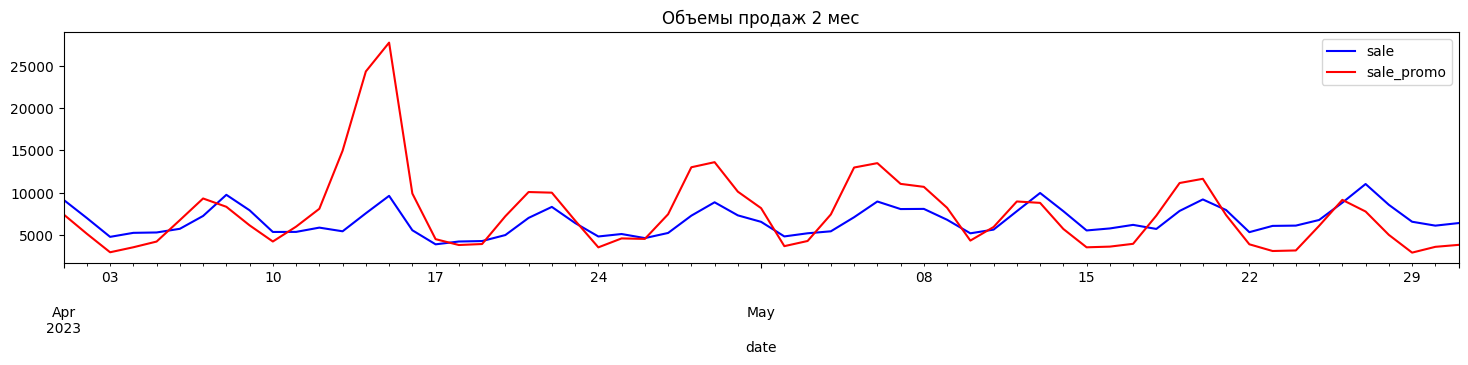

In [56]:
df[(df['date'] >= '2023-04-01') & (df['date'] <= '2023-05-31')].groupby('date')['sale'].sum().plot(legend=True,figsize=(18,3), color='b', title='Объемы продаж 2 мес')
df_promo[(df_promo['date'] >= '2023-04-01') & (df_promo['date'] <= '2023-05-31')].groupby('date')['sale_promo'].sum().plot(legend=True,figsize=(18,3), color='r')

Из графиков видно, что спрос растет в апреле 7-8, 14-15, 21-22, 28-29; в мае 5-6, 12-13, 19-20, 26-27. Закономерность очевидна - рост начинается в конце недели в пятницу и достигает пика в субботу, что объясняется выходными днями. Так же рост спроса отмечен накануне праздников.

<Axes: title={'center': 'Объемы продаж неделя'}, xlabel='day_of_week'>

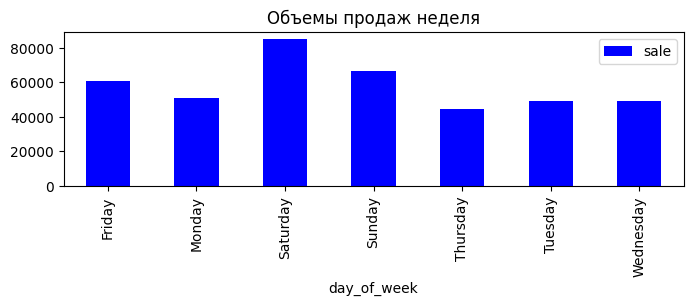

In [57]:
df[(df['date'] >= '2023-04-01') & (df['date'] <= '2023-05-31')].groupby('day_of_week')['sale'].sum().plot.bar(legend=True,figsize=(8,2), color='b', title='Объемы продаж неделя')

<Axes: title={'center': 'Объемы продаж неделя'}, xlabel='day_of_week'>

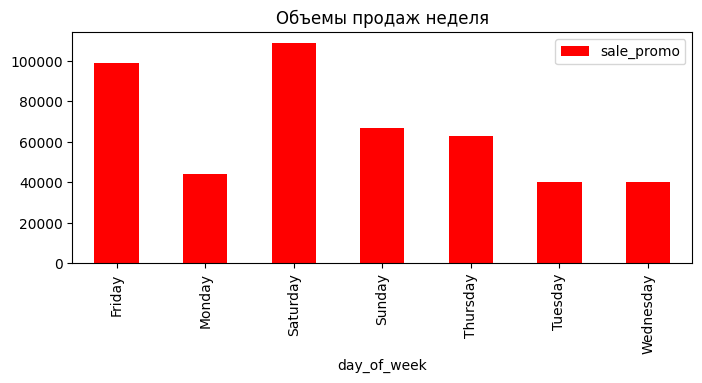

In [58]:
df_promo[(df_promo['date'] >= '2023-04-01') & (df_promo['date'] <= '2023-05-31')].groupby('day_of_week')['sale_promo'].sum().plot.bar(legend=True,figsize=(8,3), color='r', title='Объемы продаж неделя')

Выводы по уровню спроса внутри недели подтверждаются графиками внутри недели.

Дополним анализ спроса во времени анлизом тренда и сезонности, убедимся в корректности выводов.

In [59]:
df_sale = df.groupby('date')[['sale']].agg('sum').resample("1D").sum()

Разложили временной ряд на тренд и сезонную компоненту

In [60]:
decomposed = seasonal_decompose(df_sale['sale'])

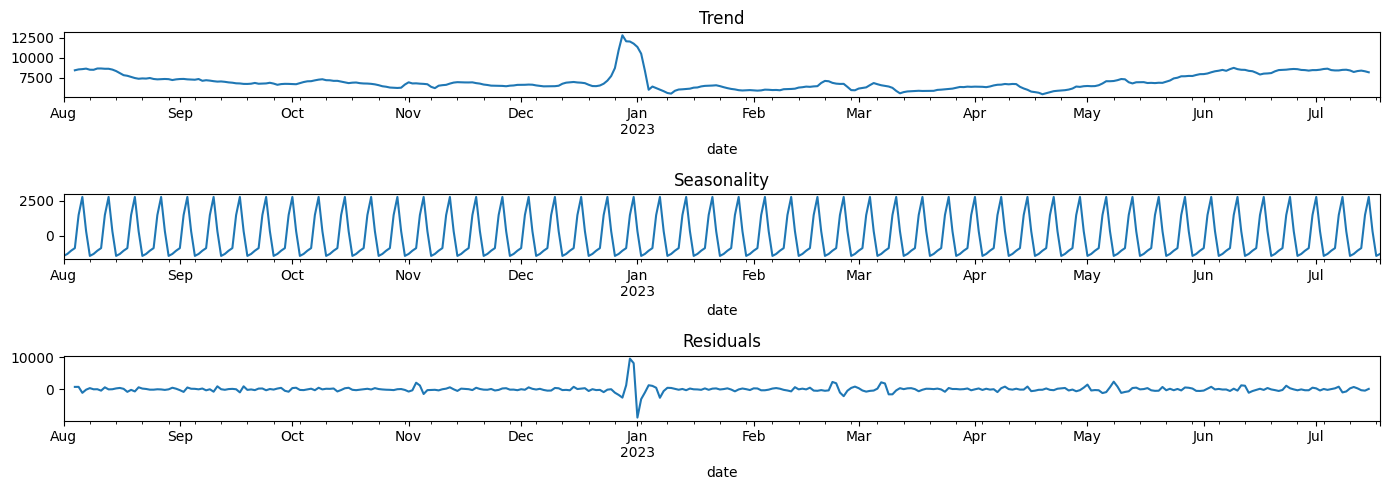

In [61]:
plt.figure(figsize=(6, 8))
plt.subplot(311)

decomposed.trend.plot(ax=plt.gca(), figsize=(14,5))
plt.title('Trend')
plt.subplot(312)

decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)

decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

Построенные графики подтверждают:

1. Есть незначительный тренд роста спроса летом
2. Скачек спроса на Новый год
3. Рост объема продаж еженедельно, начиная с пятницы и с пиком в субботу

#### Город

In [62]:
df.city.value_counts()

b8b4b727d6f5d1b61fff7be687f7970f    147716
908c9a564a86426585b29f5335b619bc    124720
c1f75cc0f7fe269dd0fd9bd5e24f9586     97647
3202111cf90e7c816a472aaceb72b0df     78896
885fe656777008c335ac96072a45be15     69505
955d864a62659945cc9434898e275deb      5071
1587965fb4d4b5afe8428a4a024feb0d       527
Name: city, dtype: int64

В городе 1587965fb4d4b5afe8428a4a024feb0d всего 2 магазина и флаг активности на данный момент установлен равным 0.

В анализе участвует 7 городов. У двух из них объем продаж сильно отличается в меньшую сторону. Вероятно небольшой магазин с низкой проходимостью

In [63]:
df[df['activ'] == 0].st_id.value_counts()

1aa057313c28fa4a40c5bc084b11d276    524
62f91ce9b820a491ee78c108636db089      3
Name: st_id, dtype: int64

In [64]:
df[df['st_id'] == '1aa057313c28fa4a40c5bc084b11d276'].date.value_counts()

2022-08-08    28
2022-08-14    27
2022-08-07    27
2022-08-11    26
2022-08-16    25
2022-08-03    24
2022-08-09    23
2022-08-10    23
2022-08-15    23
2022-08-04    22
2022-08-18    21
2022-08-02    21
2022-08-01    21
2022-08-13    21
2022-08-12    21
2022-08-17    20
2022-08-21    19
2022-08-05    19
2022-08-06    17
2022-08-22    16
2022-08-23    16
2022-08-20    13
2022-08-24    13
2022-08-19    12
2022-08-25    12
2022-08-26     4
2022-08-27     3
2022-08-28     3
2022-08-29     2
2022-08-30     1
2022-08-31     1
Name: date, dtype: int64

In [65]:
df[df['st_id'] == '62f91ce9b820a491ee78c108636db089'].date.value_counts()

2022-08-31    1
2022-09-07    1
2022-09-08    1
Name: date, dtype: int64

В 2х магазинах с активностью 0 совершено 527 торговых операций, 524 и 3. В одном в период 08-31 августа, в другов всего 3 дня: 2022-08-31, 2022-09-07,2022-09-08. Причины, почему магазины так мало работали могут быть разными, возможно их следует исключить из обучения модели.

#### Локация и окружение

In [66]:
df.location.value_counts()

1    420819
2     97647
3      5616
Name: location, dtype: int64

In [67]:
df_promo.location.value_counts()

1    292070
2     59895
3      6968
Name: location, dtype: int64

Имеется 3 типа условий по локации о окружению.


<Axes: title={'center': 'Объемы продаж в разных локациях'}, xlabel='location'>

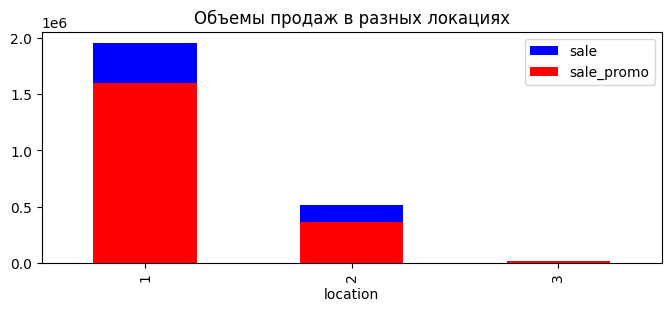

In [68]:
df.groupby('location')['sale'].sum().plot.bar(legend=True,figsize=(8,3), color='b', title='Объемы продаж в разных локациях')
df_promo.groupby('location')['sale_promo'].sum().plot.bar(legend=True,figsize=(8,3), color='r')

В условиях локаций 2 и 3(особенно) продажи будут значительно ниже, чем в 1

In [69]:
df[df['location'] == 3].st_id.value_counts()

53e19f3dbb211f20b20b45668303c1b6    4166
bd470ca955d9497bbcb808e59952fffc     905
1aa057313c28fa4a40c5bc084b11d276     524
084a8a9aa8cced9175bd07bc44998e75      18
62f91ce9b820a491ee78c108636db089       3
Name: st_id, dtype: int64

Перечень магазинов из "непопулярной локации и окружения".  Оба "быстрых" магазина здесь.

In [70]:
df.head(2)

,date,day_of_week,promo,sale,sale_promo,st_id,pr_sku_id,group,cat,subcat,uom,city,st_division_code,format,location,st_size,activ
0,2022-08-01,Monday,0,2.0,0.0,42a0e188f5033bc65bf8d78622277c4e,5781a2637b476d781eb3134581b32044,6512bd43d9caa6e02c990b0a82652dca,e58cc5ca94270acaceed13bc82dfedf7,aa50d6506c1e1b3f030c0b19962eb625,1,b8b4b727d6f5d1b61fff7be687f7970f,da742b3cfca5388aaf9af28a726a3c30,1,1,12,1
1,2022-08-01,Monday,0,2.0,0.0,c81e728d9d4c2f636f067f89cc14862c,82704fa1c2dbdb928bf4eed0667260dd,aab3238922bcc25a6f606eb525ffdc56,9701a1c165dd9420816bfec5edd6c2b1,c01c475ac8d447730ece97d846cc4f25,1,908c9a564a86426585b29f5335b619bc,429a86ff6336c144ddaf6144f52ab52c,1,1,8,1


#### Отрицательный и нулевой объем продаж

In [71]:
len(df[df['sale'] <0])

36

In [72]:
len(df_promo[df_promo['sale_promo'] <0])

35

Отрицательных значений всего 71 - вероятные возвраты. На этапе обучения их можно удалить.

In [73]:
len(df[df['sale'] ==0])

35288

In [74]:
len(df_promo[df_promo['sale_promo'] ==0])

31255

Нулевых значений всего 66543 - нужно понять, что значит уровень продаж 0. Удаляь не желательно  - большой объем информации. Если это ошибка в данных, то такая информация исказит и ухудшит результат.

Посмотрм, что это за данные

In [75]:
df[df['sale'] ==0].location.value_counts()

1    27935
2     7220
3      133
Name: location, dtype: int64

In [76]:
df[df['sale'] ==0].head()

,date,day_of_week,promo,sale,sale_promo,st_id,pr_sku_id,group,cat,subcat,uom,city,st_division_code,format,location,st_size,activ
59,2022-08-01,Monday,0,0.0,0.0,fa7cdfad1a5aaf8370ebeda47a1ff1c3,3b9ff9697e5688d38d5a0e7b0f0d519e,c74d97b01eae257e44aa9d5bade97baf,a368b0de8b91cfb3f91892fbf1ebd4b2,e2133a6d8af3a5c6f2dd40cbbaa3640f,1,885fe656777008c335ac96072a45be15,296bd0cc6e735f9d7488ebc8fbc19130,1,1,12,1
73,2022-08-01,Monday,0,0.0,0.0,fa7cdfad1a5aaf8370ebeda47a1ff1c3,f28e2941cd8ffdf35d778c3578cf7041,aab3238922bcc25a6f606eb525ffdc56,9701a1c165dd9420816bfec5edd6c2b1,3055a089cffae7c29c8942e5eb534a2a,1,885fe656777008c335ac96072a45be15,296bd0cc6e735f9d7488ebc8fbc19130,1,1,12,1
93,2022-08-01,Monday,0,0.0,0.0,16a5cdae362b8d27a1d8f8c7b78b4330,706b9e39dd3ca40669b5f5c74bfebeb8,aab3238922bcc25a6f606eb525ffdc56,28fc2782ea7ef51c1104ccf7b9bea13d,7a8aebb07d6e8ba9da453ec0f3f359a4,1,c1f75cc0f7fe269dd0fd9bd5e24f9586,296bd0cc6e735f9d7488ebc8fbc19130,1,2,8,1
108,2022-08-01,Monday,0,0.0,0.0,16a5cdae362b8d27a1d8f8c7b78b4330,90702dbda20da8380fb559b1ea8c0140,c51ce410c124a10e0db5e4b97fc2af39,535ab76633d94208236a2e829ea6d888,5fe86eaa61bb6af68ee6c47fccf3e6a5,1,c1f75cc0f7fe269dd0fd9bd5e24f9586,296bd0cc6e735f9d7488ebc8fbc19130,1,2,8,1
110,2022-08-01,Monday,0,0.0,0.0,42a0e188f5033bc65bf8d78622277c4e,fc6f1150523e511c04221a3073d2357a,aab3238922bcc25a6f606eb525ffdc56,9701a1c165dd9420816bfec5edd6c2b1,8afe22eeb3f3f68de994a3c60388858c,1,b8b4b727d6f5d1b61fff7be687f7970f,da742b3cfca5388aaf9af28a726a3c30,1,1,12,1


## Анализ и предобработка временного ряда

## Скользящее среднее

Для дальнейшего анализа временного ряда установим дату в качестве индекса.

In [77]:
df = df.set_index('date')
df.head(3)

,day_of_week,promo,sale,sale_promo,st_id,pr_sku_id,group,cat,subcat,uom,city,st_division_code,format,location,st_size,activ
date,,,,,,,,,,,,,,,,
2022-08-01,Monday,0,2.0,0.0,42a0e188f5033bc65bf8d78622277c4e,5781a2637b476d781eb3134581b32044,6512bd43d9caa6e02c990b0a82652dca,e58cc5ca94270acaceed13bc82dfedf7,aa50d6506c1e1b3f030c0b19962eb625,1,b8b4b727d6f5d1b61fff7be687f7970f,da742b3cfca5388aaf9af28a726a3c30,1,1,12,1
2022-08-01,Monday,0,2.0,0.0,c81e728d9d4c2f636f067f89cc14862c,82704fa1c2dbdb928bf4eed0667260dd,aab3238922bcc25a6f606eb525ffdc56,9701a1c165dd9420816bfec5edd6c2b1,c01c475ac8d447730ece97d846cc4f25,1,908c9a564a86426585b29f5335b619bc,429a86ff6336c144ddaf6144f52ab52c,1,1,8,1
2022-08-01,Monday,0,9.0,0.0,c81e728d9d4c2f636f067f89cc14862c,0cc8850f66397af21700e3c060a5210c,c74d97b01eae257e44aa9d5bade97baf,c559da2ba967eb820766939a658022c8,1e2248e0a1305fdf1dca5510e06a2b96,17,908c9a564a86426585b29f5335b619bc,429a86ff6336c144ddaf6144f52ab52c,1,1,8,1


дополнительная проверка хронологии

In [78]:
df.index.is_monotonic

True

Дата установлена в качестве индекса в хронологическом порядке

Скользящее среднее как признак задаёт общий тренд временного ряда. Чтобы во временном ряду снизить колебания, применим скользящее среднее.

In [79]:
df['rolling_mean'] = df['sale'].shift().rolling(14).mean()

In [80]:
df_promo['rolling_mean_promo'] = df_promo['sale'].shift().rolling(14).mean()

<Axes: title={'center': 'Средние объемы продаж и скользящее среднее'}, xlabel='date'>

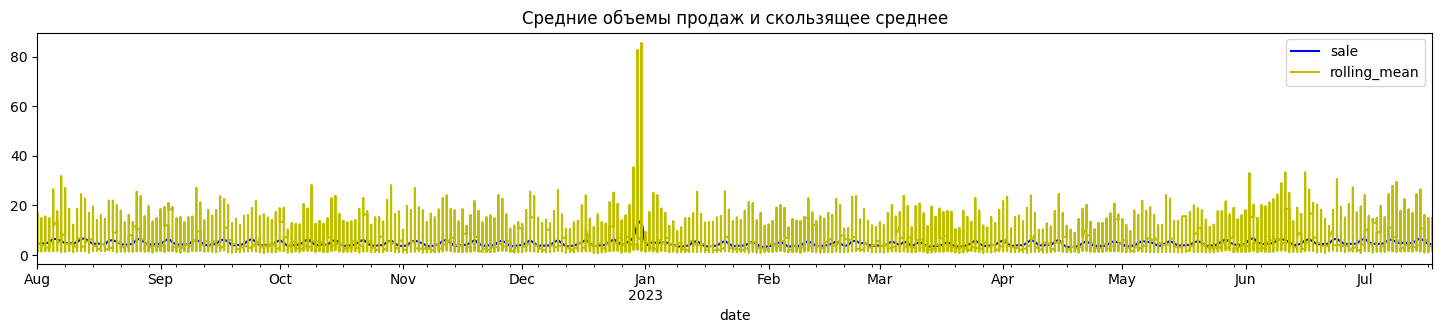

In [81]:
df.groupby('date')['sale'].mean().plot(legend=True,figsize=(18,3), color='b')
df['rolling_mean'].plot(legend=True,figsize=(18,3), color='y', title='Средние объемы продаж и скользящее среднее')

Вывод

    Получены 4 таблицы с данными

    Количество объектов 883015 - выполнено операций продажи/получено чеков за период

    Столбцов 7 - характеристики каждого чека (в роли индекса объекта выступает хэшкод магазина)

    Типы данных object, int64, float64

    Проведена анализ данных на предмет аномалий, пропуски, дубликаты и выбросы не обнаружены.
    Анализ на мультиколлениарность выяви сильную прямую зависимость столбцов  sale и sale_prom, последний удален.

    Для обучения объединены три таблицы (sales_df_train.csv, pr_df,  st_df.csv). Из полученного датасета удалена информация об уровне продаж по промоакциям.

    В поведении спроса во времени отмечена сезонность и довольно слабая зависимость спроса от времени года – летом растет, а также сильная составляющая – резкий цикличный рост спроса на продукцию в пятницу и в субботу, с дальнейшим падением. А также спрос на продукцию на новый год и пасху.


# Обучение моделей

Обучение моделей будем проводить на данных без промоакций. Для прогноза спроса по промоакциям можно построить отдельную модель

## Подготовка данных к обучению

### Данные без промо

Удаляем признак sale_promo - мультиколлениарность

In [82]:
df = df.drop(['sale_promo'] , axis=1)

Горизонт прогнозирования = 14 дней

Уровень спроса - количественный признак, поэтому прогноз количества заявок - это задача регрессии.

Функция добавляет новые признаки с отстающими по дате значениями

In [83]:
def make_features(data, max_lag):

    i=0
    for i in range(1, max_lag+1):
        data['lag_{}'.format(i)] = df['sale'].shift(i)

make_features(df, 14)

Удаление пропусков NaN первых значений из-за "отставания" и пропусков после добавления среднего сеользящего

In [84]:
len(df)

524082

In [85]:
df = df.dropna()

In [86]:
len(df)

524068

### Выделение целевого признака

In [87]:
x = df.drop(['sale'] , axis=1)

In [88]:
y = df['sale']

### Разделение выборки

Разделяем исходные данные на train и test в пропорции - проведем до получения тестовых данных оценку моделей. Разделяем без перемешивания, т.к временные ряды обучаются на прошлом, валидируются и проверяются на будущем.

In [89]:
x_train, x_test, y_train, y_test = train_test_split(x, y, shuffle=False, test_size=0.1)

Проверка размеров выборок

In [90]:
len(df) - len(x_train) - len(x_test)

0

In [91]:
len(df)

524068

In [92]:
len(x_train)

471661

In [93]:
len(x_test)

52407

После разделения имеем следующие выборки

1. обучающая выборка

   x_train - признаки   
   y_train - целевой признак
   
   
2. тестовая выборка

   x_test - признаки   
   y_test - целевой признак

Переход от выборки к выборке

In [94]:
display(x_train.tail(2))
display(x_test.head(2))

,day_of_week,promo,st_id,pr_sku_id,group,cat,subcat,uom,city,st_division_code,format,location,st_size,activ,rolling_mean,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2023-06-16,Friday,0,42a0e188f5033bc65bf8d78622277c4e,6f14138e00dfafe64dd7d51ac3d0d792,aab3238922bcc25a6f606eb525ffdc56,b7087c1f4f89e63af8d46f3b20271153,aa7420bcdec6c0ce8dc01394aaa498f2,17,b8b4b727d6f5d1b61fff7be687f7970f,da742b3cfca5388aaf9af28a726a3c30,1,1,12,1,2.785714,3.0,0.0,0.0,5.0,1.0,2.0,3.0,2.0,2.0,9.0,8.0,2.0,2.0,0.0
2023-06-16,Friday,0,c81e728d9d4c2f636f067f89cc14862c,0e1e064746347f5896ca4ff8b568f3a6,aab3238922bcc25a6f606eb525ffdc56,28fc2782ea7ef51c1104ccf7b9bea13d,d29b5ce9c2883f0b7e90f79071a2ca82,1,908c9a564a86426585b29f5335b619bc,429a86ff6336c144ddaf6144f52ab52c,1,1,8,1,2.857143,1.0,3.0,0.0,0.0,5.0,1.0,2.0,3.0,2.0,2.0,9.0,8.0,2.0,2.0


,day_of_week,promo,st_id,pr_sku_id,group,cat,subcat,uom,city,st_division_code,format,location,st_size,activ,rolling_mean,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2023-06-16,Friday,0,fa7cdfad1a5aaf8370ebeda47a1ff1c3,cfa2eba0e5c031e0d78a6b4529882e80,aab3238922bcc25a6f606eb525ffdc56,46771d1f432b42343f56f791422a4991,38cc804f2e8d4b18785b84c68517eadf,1,885fe656777008c335ac96072a45be15,296bd0cc6e735f9d7488ebc8fbc19130,1,1,12,1,2.714286,0.0,1.0,3.0,0.0,0.0,5.0,1.0,2.0,3.0,2.0,2.0,9.0,8.0,2.0
2023-06-16,Friday,0,16a5cdae362b8d27a1d8f8c7b78b4330,b739e0ffbd85602c82b57468fc48aa6f,c74d97b01eae257e44aa9d5bade97baf,faafda66202d234463057972460c04f5,58c9ac72725ab1211b35821c610dcd6b,1,c1f75cc0f7fe269dd0fd9bd5e24f9586,296bd0cc6e735f9d7488ebc8fbc19130,1,2,8,1,2.642857,1.0,0.0,1.0,3.0,0.0,0.0,5.0,1.0,2.0,3.0,2.0,2.0,9.0,8.0



Данные временного ряда разделены корректно train-test, без
перемешивания, одна выбока является продолжением другой по индексу и значению признаков lag

Предобработка признаков (масштабирование, кодирование, векторизация) каждый раз должна проводиться независимо, иначе происходит утечка данных.

## Обучение модели LinearRegression и проверка.

### Кодирование признаков

In [96]:
x_train = pd.get_dummies(x_train, drop_first=True)

In [97]:
x_train.head()

promo  uom  format  location  st_size  activ  rolling_mean  lag_1  \
date                                                                            
2022-08-01      0    1       1         1       12      1      3.928571    3.0   
2022-08-01      0    1       1         1       12      1      3.857143    1.0   
2022-08-01      0    1       1         1       12      1      3.785714    1.0   
2022-08-01      0    1       1         1       12      1      3.357143    3.0   
2022-08-01      0   17       1         1        8      1      2.642857    3.0   

            lag_2  lag_3  lag_4  lag_5  lag_6  lag_7  lag_8  lag_9  lag_10  \
date                                                                         
2022-08-01    2.0    1.0    2.0    4.0    3.0    4.0    3.0    5.0     2.0   
2022-08-01    3.0    2.0    1.0    2.0    4.0    3.0    4.0    3.0     5.0   
2022-08-01    1.0    3.0    2.0    1.0    2.0    4.0    3.0    4.0     3.0   
2022-08-01    1.0    1.0    3.0    2.0    1.0    2.0    4.0    3.0     4.0   
2022-08-01    3.0    1.0    1.0    3.0    2.0    1.0    2.0    4.0     3.0   

            lag_11  lag_12  lag_13  lag_14  day_of_week_Monday  \
date                                                             
2022-08-01    13.0     9.0     2.0     2.0                   1   
2022-08-01     2.0    13.0     9.0     2.0                   1   
2022-08-01     5.0     2.0    13.0     9.0                   1   
2022-08-01     3.0     5.0     2.0    13.0                   1   
2022-08-01     4.0     3.0     5.0     2.0                   1   

            day_of_week_Saturday  day_of_week_Sunday  day_of_week_Thursday  \
date                                                                         
2022-08-01                     0                   0                     0   
2022-08-01                     0                   0                     0   
2022-08-01                     0                   0                     0   
2022-08-01                     0                   0                     0   
2022-08-01                     0                   0                     0   

            day_of_week_Tuesday  day_of_week_Wednesday  \
date                                                     
2022-08-01                    0                      0   
2022-08-01                    0                      0   
2022-08-01                    0                      0   
2022-08-01                    0                      0   
2022-08-01                    0                      0   

            st_id_16a5cdae362b8d27a1d8f8c7b78b4330  \
date                                                 
2022-08-01                                       0   
2022-08-01                                       0   
2022-08-01                                       0   
2022-08-01                                       0   
2022-08-01                                       0   

            st_id_1aa057313c28fa4a40c5bc084b11d276  \
date                                                 
2022-08-01                                       0   
2022-08-01                                       0   
2022-08-01                                       0   
2022-08-01                                       0   
2022-08-01                                       0   

            st_id_1ecfb463472ec9115b10c292ef8bc986  \
date                                                 
2022-08-01                                       0   
2022-08-01                                       0   
2022-08-01                                       0   
2022-08-01                                       0   
2022-08-01                                       0   

            st_id_42a0e188f5033bc65bf8d78622277c4e  \
date                                                 
2022-08-01                                       1   
2022-08-01                                       0   
2022-08-01                                       0   
2022-08-01                                       0   
2022-08-01         

### Масштабирование признаков

Приведение непрерывных значений признаков к единому масштабу.
Для выборки train применяется метод fit и transform совместно - fit_transform, а для выборки test - transform

In [1]:
list_1 = list(x_train.columns)

numeric = list_1

scaler = StandardScaler()

x_train[numeric] = scaler.fit_transform(x_train[numeric])

x_train[numeric] = scaler.transform(x_train[numeric])

NameError: ignored

In [95]:
%%time

# обучение модели на параметрах
model_linear_regression = LinearRegression(fit_intercept=False)
model_linear_regression = model_linear_regression.fit(x_train, y_train)

# Предсказание модели на тестовой выборке
predictions_test_linear_regression = model_linear_regression.predict(x_test)

# прогноз и RMSE на тестовой выборке
rmse_test_linear_regression = mean_squared_error(y_test, predictions_test_linear_regression)**.5
display(model_linear_regression)
display('RMSE = {}'. format(rmse_test_linear_regression))

ValueError: ignored

<div style="background: #E5E4D7; padding: 5px; border: 1px solid grey; border-radius: 5px;">
<font color='gray'>
<b><u>Вывод:</u></b>
</font>
<font color='gray'>
    
- Модель LinearRegression обучилась за время 3.43s с уровнем качества RMSE = 55.11876

###  Обучение модели DecisionTreeRegressor и проверка.

In [ ]:
%%time

# модель
model_decision_tree_regressor = DecisionTreeRegressor(random_state=STATE)

# сетка параметров
params_decision_tree_regressor = {
    'max_depth':[x for x in range(13, 16, 1)],
    'min_samples_leaf':[x for x in range(10, 12, 1)],
    'min_samples_split':[x for x in range(30, 34, 1)]
}

split_index = TimeSeriesSplit(n_splits=8)
grid = GridSearchCV(model_decision_tree_regressor, params_decision_tree_regressor, cv=split_index)

# обучение модели на параметрах
model_decision_tree_regressor = grid.fit(x_train, y_train).best_estimator_
model_decision_tree_regressor

# прогноз и RMSE на валидационной выборке
predictions_test_decision_tree_regressor = model_decision_tree_regressor.predict(x_test)
rmse_test_decision_tree_regressor = mean_squared_error(y_test, predictions_test_decision_tree_regressor)**.5
display(model_decision_tree_regressor)
display('RMSE = {}'. format(rmse_test_decision_tree_regressor))

<div style="background: #E5E4D7; padding: 5px; border: 1px solid grey; border-radius: 5px;">
<font color='gray'>
<b><u>Вывод:</u></b>
</font>
<font color='gray'>
    
- Модель DecisionTreeRegressor обучилась за время 3.7s (условно - параметры предустановлены) с уровнем качества RMSE = 41.389 с параметрами {'max_depth': 9, 'min_samples_leaf': 7, 'min_samples_split': 25}

<div style="background: #cceeaa; padding: 5px; border: 1px solid green; border-radius: 5px;">
<font color='green'>
    <b><u>КОММЕНТАРИЙ РЕВЬЮЕРА</u></b>
</font>
<font color='red'><br>
В нашем случае для поиска гиперпараметров сложновато воспользоваться встроенной в grid search cv, потому что она не учитывает, что у нас временной ряд и валидационная часть выборки при каждом разбиении должна быть позже обучающей. Поэтому, лучше воспользоватся методами из sklearn:	<br><br>
split_index = TimeSeriesSplit()..<br>
cb_searcher = GridSearchCV(	.....   cv=split_index....)<br>

Или более облегчённый вараинт.<br>
tscv = TimeSeriesSplit(n_splits=8)(надо посмотерть, как подобрать параметр и аргументировать)<br>
gsearch = GridSearchCV(gbm, param_grid=param_set, scoring='neg_mean_squared_error', n_jobs=-1, cv=tscv, verbose=1)  

<div style="background: #ffeeaa; padding: 5px; border: 1px solid green; border-radius: 5px;">
<font color='green'>
<u>КОММЕНТАРИЙ РЕВЬЮЕРА</u>
</font>
<font color='green'><br>
n_splits , обычно, задают так, чтобы размер валидационной выборки при проведении кросс-валидации примерно совпадал с размером тестовой выборки. Размер тестовой выборки у нас 10%, а размер валидационной равен 1/(n_splits+1) части от обучающей выборки (см. документацию к TimeSeriesSplit). К примеру, если n_splits=2, то размер валидационной равен 1/3 от обучающей выборки, т.е. 1/3*90%=30% от исходной выборки.<br>
Возможно, что n_splits=8, то 1/9*90%=10%  - будет более точное попадание.

<div class="alert alert-info">
<h3>Комментарий студента v1 <a class="tocSkip"></a></h3>
   
Исправлен способ подбора гиперпараметров, выбрал 1й вариант - показался проще.
    
split_index = TimeSeriesSplit()..
    
cb_searcher = GridSearchCV( ..... cv=split_index....)   
    
Не уверен, что корректно применил. Прверь пожалуйста
</div>


<div style="background: #cceeaa; padding: 5px; border: 1px solid green; border-radius: 5px;">
<font color='green'>
<u>КОММЕНТАРИЙ РЕВЬЮЕРА 2</u>
</font>
<font color='green'><br>
Тут такие есть варианты:<br>
    
1)split_index = TimeSeriesSplit().split(features_train)<br>
2)split_index = TimeSeriesSplit(n_splits=8)<br>
    
Всё зависит от библиотек и обновени......<br>
Я чаще использую второй вариант.

### Обучение модели RandomForestRegressor и проверка.¶

In [ ]:
%%time

# модель
model_random_forest_regressor = RandomForestRegressor(random_state=STATE)

# сетка параметров
params_random_forest_regressor = {
    'max_depth':[x for x in range(14, 17, 1)],
    'min_samples_leaf':[x for x in range(5, 6, 1)],
    'min_samples_split':[x for x in range(2, 4, 1)],
    'n_estimators':[x for x in range(102, 103, 1)]
}

# обучение модели на параметрах
split_index = TimeSeriesSplit(n_splits=8)
grid = GridSearchCV(model_random_forest_regressor, params_random_forest_regressor, cv=split_index)
model_random_forest_regressor = grid.fit(x_train, y_train).best_estimator_


# прогноз и RMSE на валидационной выборке
predictions_test_random_forest_regressor = model_random_forest_regressor.predict(x_test)
rmse_test_random_forest_regressor = mean_squared_error(y_test, predictions_test_random_forest_regressor)**.5
display(model_random_forest_regressor)
display('RMSE = {}'. format(rmse_test_random_forest_regressor))

<div style="background: #E5E4D7; padding: 5px; border: 1px solid grey; border-radius: 5px;">
<font color='gray'>
<b><u>Вывод:</u></b>
</font>
<font color='gray'>
    
- Модель RandomForestRegressor обучилась за время до 12.1s (условно - параметры предустановлены) с уровнем качества RMSE = 51.467 с параметрами max_depth=10, min_samples_leaf=3, min_samples_split=14, min_weight_fraction_leaf=0.0, n_estimators=106

### Обучение модели CatBoostRegressor и проверка.

Инициализация модели CatBoostRegressor

обучение модели на тренировочной выборке

In [ ]:
%%time

# модель
model_cat_boost_regressor = CatBoostRegressor(iterations = 1000, metric_period=50, max_depth=4)

# обучение модели на параметрах
model_cat_boost_regressor.fit(x_train, y_train)

# прогноз и RMSE на валидационной выборке
predictions_test_cat_boost_regressor = model_cat_boost_regressor.predict(x_test)
rmse_test_cat_boost_regressor = mean_squared_error(y_test, predictions_test_cat_boost_regressor)**.5
display(model_cat_boost_regressor)
display('RMSE = {}'. format(rmse_test_cat_boost_regressor))

<div style="background: #E5E4D7; padding: 5px; border: 1px solid grey; border-radius: 5px;">
<font color='gray'>
<b><u>Вывод:</u></b>
</font>
<font color='gray'>
    
- Модель CatBoostRegressor обучилась за время 35.1 s с уровнем качества RMSE = 36.411 без настройки геперпараметров

### Таблица сравнения моделей на валидационной выборке

data_valid = {'model':['Linear_Regression', 'Decision_Tree_Regressor', 'Random_Forest_Regressor',  'CatBoostRegressor'],
        'rmse_valid':[rmse_valid_linear_regression, rmse_valid_decision_tree_regressor,
                      rmse_valid_random_forest_regressor, rmse_valid_cat_boost_regressor],
        'time':['3.43', '3.7 *', '12.1 *',  '35.1'],
       }

# Создать DataFrame
pd.set_option('display.float_format', '{:.10g}'.format)
data_valid_models = pd.DataFrame(data_valid)
data_valid_models.sort_values(by='rmse_valid')

<div style="background: #E5E4D7; padding: 5px; border: 1px solid grey; border-radius: 5px;">
<font color='gray'>
<b><u>Вывод:</u></b>
</font>
<font color='gray'>

- Таблица data_valid_models демонстрирует качество 4 моделей по метрике качества RMSE на валидационной выборке

- Значения признака RMSE сортированы по возрастанию - сверху самая точная модель

<div class="alert alert-info">
<h3>Комментарий студента v1 <a class="tocSkip"></a></h3>
   
Добавлен вывод
    
**Вывод:**
    
обучены четыре модели 'Linear_Regression', 'Decision_Tree_Regressor', 'Random_Forest_Regressor',  'CatBoostRegressor'с приемлемым уровнем качества RMSE < 48 (целевой уровень достигнут предварительно) и приемлемым временем обучения (не является оценочным критерием)
</div>

## Тестирование

Значение метрики RMSE на тестовой выборке должно быть не больше 48.

### Тестирование модели LinearRegression

In [ ]:
predictions_test_linear_regression = model_linear_regression.predict(x_test)
rmse_test_linear_regression = mean_squared_error(y_test, predictions_test_linear_regression)**.5
'RMSE = {}'. format(rmse_test_linear_regression)

### Тестирование модели DecisionTreeRegressor

In [ ]:
predictions_test_decision_tree_regressor = model_decision_tree_regressor.predict(x_test)
rmse_test_decision_tree_regressor = mean_squared_error(y_test, predictions_test_decision_tree_regressor)**.5
'RMSE = {}'. format(rmse_test_decision_tree_regressor)

### Тестирование модели RandomForestRegressor

In [ ]:
predictions_test_random_forest_regressor = model_random_forest_regressor.predict(x_test)
rmse_test_random_forest_regressor = mean_squared_error(y_test, predictions_test_random_forest_regressor)**.5
'RMSE = {}'. format(rmse_test_random_forest_regressor)

### Тестирование модели CatBoostRegressor

In [ ]:
predictions_test_cat_boost_regressor = model_cat_boost_regressor.predict(x_test)
rmse_test_cat_boost_regressor = mean_squared_error(y_test, predictions_test_cat_boost_regressor)**.5
'RMSE = {}'. format(rmse_test_cat_boost_regressor)

<div class="alert alert-info">
<h3>Комментарий студента v1 <a class="tocSkip"></a></h3>
   
Первая итерация тестирования моделей на тестовой выборке показала превышение целевого уровня RMSE <= 48
                                                                                                      
Требуется провести корректировку гиперпараметров моделей
                                                                                                      
Linear_Regression	58.55996486
    
Random_Forest_Regressor	58.96245794
    
CatBoostRegressor	59.14720946
    
Decision_Tree_Regressor	59.56819237
    
</div>

<div style="background: #cceeaa; padding: 5px; border: 1px solid green; border-radius: 5px;">
<font color='green'>
<b><u>КОММЕНТАРИЙ РЕВЬЮЕРА 2</u></b>
</font>
<font color='green'><br>Да уж, не густо:)

### Таблица сравнения моделей на тестовой выборке.

In [ ]:
data_valid_test = {
    'model':['Linear_Regression', 'Decision_Tree_Regressor', 'Random_Forest_Regressor',  'CatBoostRegressor'],
    'rmse_test':[rmse_test_linear_regression, rmse_test_decision_tree_regressor,
                 rmse_test_random_forest_regressor, rmse_test_cat_boost_regressor],
    'time':['8.55 s', '41.4 s', '1h 48min 36s',  '22.9 s']
}

# Создать DataFrame
pd.set_option('display.float_format', '{:.10g}'.format)
data_valid_test_models = pd.DataFrame(data_valid_test)
data_valid_test_models.sort_values(by='rmse_test')

<div class="alert alert-info">
<h3>Комментарий студента v1 <a class="tocSkip"></a></h3>
   
Первая итерация тестирования моделей на тестовой выборке показала превышение целевого уровня RMSE <= 48
                                                                                                      
Требуется провести корректировку гиперпараметров моделей
                                                                                                      
Linear_Regression	58.55996486
    
Random_Forest_Regressor	58.96245794
    
CatBoostRegressor	59.14720946
    
Decision_Tree_Regressor	59.56819237
    
</div>

<div style="background: #E5E4D7; padding: 5px; border: 1px solid gray; border-radius: 5px;">
<font color='gray'>
<b><u>Вывод:</u></b>
</font>
<font color='gray'>
    
- Таблица data_valid_test_models демонстрирует качество 4 моделей по метрике качества RMSE на тестовой и валидационной выборке

- Значения признака RMSE_test сортированы по возрастанию - сверху самая точная модель
    
- Тестирование на тестовой выборке показало, что настройкой гиперпараметров моделей RandomForestRegressor и CatBoostRegressor удалось добиться значение метрики RMSE не больше 48
    
- учитывая время обучения и точность моделей, считаем, что CatBoostRegressor наиболее оптимальна в данной задаче.

### Визуализация сравнения фактического и прогнозного количества вызовов такси

Таблица данных для сравнения

In [ ]:
plot_compare = y_test.to_frame()

Начало и конец периода сравнения

In [ ]:
display(plot_compare['2018-08-17 00:00:00':'2018-08-19 23:00:00'].head(2))

In [ ]:
display(plot_compare['2018-08-17 00:00:00':'2018-08-19 23:00:00'].tail(2))

График сравнения фактического и прогнозного количества вызовов такси за период сравнения

In [ ]:
plot_compare.head(3)

In [ ]:
plot_compare['predict'] = predictions_test_cat_boost_regressor
plot_compare['2018-08-17 00:00:00':'2018-08-19 23:00:00'].plot(figsize=(16, 6), grid=True)

<div style="background: #E5E4D7; padding: 5px; border: 1px solid gray; border-radius: 5px;">
<font color='gray'>
<b><u>Вывод:</u></b>
</font>
<font color='gray'>
    
- График сравнения фактического и прогнозного на модели CatBoostRegressor количества вызовов такси за период сравнения 2018-08-17 00:00:00':'2018-08-19 23:00:00 демонстрирует, что прогноз количества вызовов такси в целом очень близок к фактическому.

<div style="background: #cceeaa; padding: 5px; border: 1px solid green; border-radius: 5px;">
<font color='green'>
<b><u>КОММЕНТАРИЙ РЕВЬЮЕРА 2</u></b>
</font>
<font color='green'><br>ОК, Евгений. Движение - в ту самую сторону!<br>
Порпобуй с фактором скользящее среднее устновить 24. Выше написал аргументацию...<br>
А т.к. у тебя используется кросс-валидация, то исключить валидационную выборку. Тогда трайн будет более полный и сможем ещё схватить для модели нужной информации (сейчас вот из графика видно, что модель часто не допрогнозирует - сам график ниже факт чаще всего)...<br>
    
Буду ждать)

<div class="alert alert-info">
<h3>Комментарий студента v2 <a class="tocSkip"></a></h3>
   
**Вывод:**

Для достижения целевого уровня RMSE < 48, попробовал разные варианты настроек (признаки, настройки обучения модели и гиперпараметров). Получилось только при увеличении среднего скользящего до 24 и log до 7!!! (видимо это некорректно), другого результата пока нет, продолжу поиск.
                                         
Модель CatBoostRegressor получила метрику RMSE = 46    
</div>

<div style="background: #cceeaa; padding: 5px; border: 1px solid green; border-radius: 5px;">
<font color='green'>
<b><u>КОММЕНТАРИЙ РЕВЬЮЕРА 3 (25/07/2021)</u></b>
</font>
<font color='green'><br>Привет, Евгений.<br>
Увидел твои доработки, отлично! СКользящее среднее = 24 - это хорошее решение. Лаг = 7  - это тоже не плохое решение.Хотя есть такая рекоммендация у некторых специалистов: нужно стараться получить лучшую по качеству модель с наименьшим количеством фаткоров... Но формально у тебя проект уже сделан и результат достигнут. Т.е. могу с чистой совестью ОК-уть. А дальше только - тюнинг....:)<br>

Поэтому, тут выбор сейчас за тобой  - можно попробовать ещё поподбирать вараинты, можно закончить... <br>

<div class="alert alert-info">
<h3>Комментарий студента v3 <a class="tocSkip"></a></h3>
   
Привет, Николай!
    
Проработаю еще вариант, в котором попробую указать в моделях минимально-возможное количество параметров, а так же другие настроки моделей и данных.
    
Я не совсем понял, **"получить лучшую по качеству модель с наименьшим количеством факторов"** - это про настройки или данные сета и lag?
    
Знаний не хватает найти пути решения))
</div>

<div style="background: #cceeaa; padding: 5px; border: 1px solid green; border-radius: 5px;">
<font color='green'>
<b><u>КОММЕНТАРИЙ РЕВЬЮЕРА 3 (26/07/2021)</u></b>
</font>
<font color='green'><br>Привет, Евгений.<br>
Смотри какое дело: я сейчас всё аккуратно прогнал с самого начала. Именно с того момента, когда считываем исходный датасет. Потом ресемплирование. Потом СРАЗУ перехожу на функцию создания фаткоров - вставил в блок между ****** чуть скорректированный вариант. Далее расчёт и модели. И всё получилось... Т.е. у тебя всё сделано уже - просто файл data уже создан. И если сейчас ещё раз прогнать - результат изменится... А чтобы не изменился результат - лучше прогонять именно со считывания исходных данных заново. (ну или copy() применить..., чтобы не считывать заново всё время)...<br>
    
В общем всё, вроде работает.... посмотри, поалуйста, тоже - может я что-то где-то упустил....

<div class="alert alert-info">
<h3>Комментарий студента v4 (26/07/2021) <a class="tocSkip"></a></h3>
   
Привет, Николай!
    
1. Фаткор - 2й раз вижу это слово. Это опечатка от "фактор" или фаткор означает данные типа lag, rolling_mean  и т.д. ??
    
2. Спасибо за помощь, много лишнего в коде и в работе в целом мной рассмотрено изначально - ничего не удалил для истории. Алгоритм выполнения кода следующий:
    
 1.1	выполняем загрузка данных

 1.2	выполняем общий анализ датасета

 1.3	пропускаем лишний пункт 2.2  Распределение заказов во времен. Признак «Среднее скользящее» добавим позже используя
    функцию. Анализ распределений прпускаем как малоинформативный для данного датасета и задачи.

   При создании признака «Среднее скользящее» была ошибка – сейчас исключена (добавлялся дважы, один раз с константно      
   data['rolling_mean'] = data['num_orders'].shift().rolling(**5**).mean())

   1.4	выполняем пункт «Обучение» - датасет делим без валидационной выборки


</div>

<div style="background: #cceeaa; padding: 5px; border: 1px solid green; border-radius: 5px;">
<font color='green'>
<u>КОММЕНТАРИЙ РЕВЬЮЕРА</u>
</font>
<font color='green'><br>
Евгений, с модельной частью справился хорошо!<br>
Видно, что этот скил уже достаточно сильный у тебя.<br>
Метрика - ОК. Но не понятно, если честно, а хороша ли эта модель в плане предсказания? Для этого лучше построить дополнительно график (чуть ниженаписал об этом).<br>
    
И если сутейно рассуждать, то временные ряды стоят особняком во всём курсе, я бы сказал. Тут чуть иная модельная философия, на мой взгляд. Имменно поэтому позволял себе оставлять большие комментарии, чтобы как-то раскрыть её особенности.<br>
    
<font color='red'>   
1)Оставил несколько комментариев в тексте - готов буду ответить на твои вопросы!<br>    
    
2)Также, попрошу тебя чуть скорректировать такой момент:<br>
Выведи, пожалуйста графики факт/предсказанное на одном рисунке (обычный линейный график - пример ниже). Чтобы увидеть где основные не "попадалки" модели. Это один из важнейших инструментов анализа результатов моделирования временных рядов.<br>
Лучше выбрать масштаб, скажем, несколько дней, чтобы увиеть можо было и сравнить каждый час.<br>    
<font color='green'>
Спасибо)<BR>
БУДУ ЖДАТЬ КОММЕНТАРИЕВ

![image.png](attachment:image.png)

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Данные загружены и подготовлены
- [ ]  Данные проанализированы
- [ ]  Модель обучена, гиперпараметры подобраны
- [ ]  Качество моделей проверено, выводы сделаны
- [ ]  Значение *RMSE* на тестовой выборке не больше 48

<div style="background: #cceeaa; padding: 5px; border: 1px solid green; border-radius: 5px;">
<font color='green'>
<u>КОММЕНТАРИЙ РЕВЬЮЕРА</u>
</font>
<font color='green'><br>
Хотел бы оставить несколько идей для твоих будущих проектов в этой обоасти<br>

На мой взгляд, в этой теме (временные ряды) главное - необходимо чувствовать исходный ряд продаж, с точки зрения бизнеса, и уже только потом подбирать к нему модели. Каждое колебание временного ряда - это деньги для бизнеса (если говорим что заказчик бизнесовый) и за "трепетами" данных прячутся разные семейства причин. И именно знание их помогут строить хорошие прогнозы..<br>.
Леса, бустинги, регрессии.... могут подобрать хорошие модели на старых данных. Но иногда, как прогноз эти, модели могут оказаться пустышками - не интересными бизнесу. <br>  <br>
Поэтому, от себя позволю добавить несколько идей:<br>
Очень часто ищут "волшебную таблетку" или "кнопку". Нажал и само всё построилось с высокой точностью<br>
Но такого никогода не будет)))<br>
И причиной тому: модели нужно подсказать причины, по которым происходит колебания продаж (временного ряда): понимать причины колебаний треда, понимать аномалии, учитывать акционные продажи, видеть действия конкурентов , закладывать их в модель и т.д. <br><br>
В общем, всё как обычно - три группы факторов: <br>
1)внешние факторы (например выручка такси-компании зависит от количества машин на линии),<br>
2)есть факторы внутри самих данных (Вы использовали как раз поняти лаг, сезонности), <br>
3)есть параметры самих моделей (то, что обычно используется при моделировании леса или деревьев).<br><br>

Ещё важно иметь ввиду горизонт прогноза: на кокой период строить прогноз нужно  - на час вперёд, на неделю, на месяц.<br>
Это также накладывает ограничения на подбор моделей<br>
Я бы рекомендовал Вам составить для себя матрицу  в разрезе: <br>
а)есть тренд/нет тренда; <br>
б)еть сезоннотсь/нет сезонности; <br>
в)какой горизонт прогноза требуется; <br>
г) есть ли у нас дополнительные факторы для модей<br>
На пересечении знаний о моделях легко будет подобрать адкватную модель.
Не все задачи прогнозирования временных рядов можно хорошо решить лесом и еже с ним на основе знаний только факторов ряда... Они хорошо подойдут для коротких горизонтов прогнозирования.... А если горизонт чуть больше: недели, месяцы... то тут надо подключать понимания фаткоров продаж самого бизнеса.